# NN design

Define and test some NN architectures and data vars. Train the models with the limited 21 day period of local data.

In [1]:
# 
from sklearn.model_selection import train_test_split
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys

sys.path.append("../")
from src.processing import windsat_datacube, create_landmask


<xarray.Dataset> Size: 4GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/14)
    longitude       (day_number, longitude_grid, latitude_grid) float32 87MB dask.array<chunksize=(1, 1440, 720), meta=np.ndarray>
    latitude        (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    node            (day_number, swath_sector, latitude_grid, longitude_grid) float64 348MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band, latitude_grid, longitude_grid) float32 174MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band, latitude_grid, longitude_grid) float32 174MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band, latitude_grid, longitude_grid) float32 174MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    ...              ...
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) float64 348MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    landmask        (latitude_grid, longitude_grid) float64 8MB 0.0 0.0 ... nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

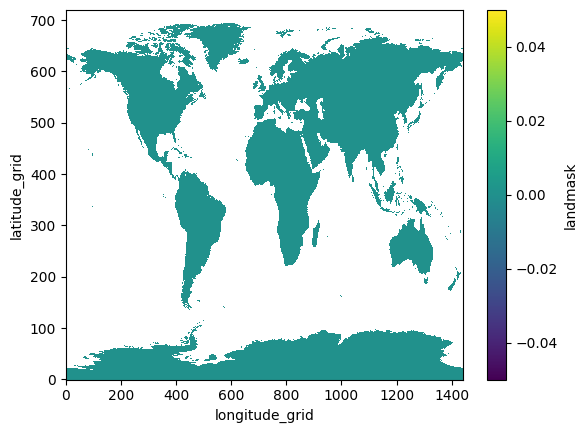

In [2]:
# Load the data in the folder
folder_path = "../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path=folder_path)
# Add the landmask and filter the dataset with only the land pixels

landmask = create_landmask(lat=ds.lat.values, lon=ds.lon.values)
ds["landmask"] = (("latitude_grid","longitude_grid"), landmask.values)

ds.landmask.attrs = {
    "Description": "Landmask object from regionmask, 0 for Land pixels, NaN for ocean"
}
ds.landmask.plot()

# Filter the ocean pixels
ds=ds.where(ds.landmask == 0)
ds

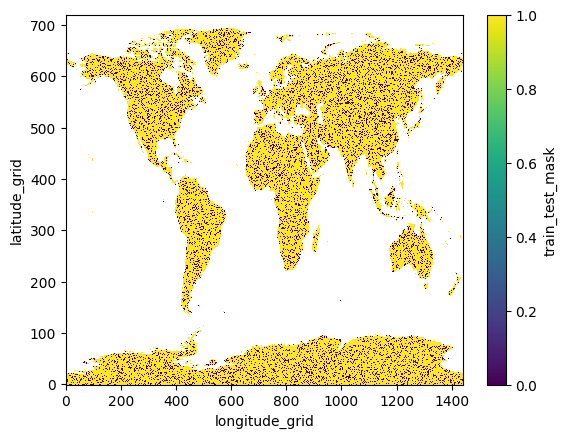

In [3]:
# Create the train-test mask
#TODO: Maybe worthit to wrap this into a function? 
land_indeces = np.argwhere(ds.landmask.values == 0)
train_indeces , test_indeces = train_test_split(land_indeces, test_size=0.2, random_state=13)
train_test_mask = np.copy(landmask)
train_test_mask[train_indeces[:,0], train_indeces[:,1]] = 1

ds["train_test_mask"] = (("latitude_grid", "longitude_grid"), train_test_mask)
ds.train_test_mask.attrs = {
    "Desccirption": "Random mask for train test split based on latitude and longitude (same for all days). Nan for Ocean, 0 for test, 1 for train"
}
ds.train_test_mask.plot()

In [4]:
# Separate the datastet( kind of redundant but is clearer for the user)
trainds = ds.where(ds.train_test_mask == 1)
testds = ds.where(ds.train_test_mask == 0)

# 2017 paper on nn architecture
""" 

Multilayer perceptrons are used to implement each neural network. The input layer has as many nodes as
the number of frequency channels and associated emissivities used for the inversion. It is followed by a hidden layer of 10 nodes, and the output layer with one node for the retrieved Ts. For the training, 105 cases
are randomly selected from the Tbs-Ts database. The initial weights of the neural network are randomly initialized by the Nguyen-Widrow algorithm [Nguyen and Widrow, 1990], and the final weights are assigned by
a Marquardt-Levenberg backpropagation algorithm [Hagan and Menhaj, 1994]. To prevent overfitting to the
training data set, a cross-validation technique is used to monitor the evolution of the training error function

"""

For now I will not use emissivities, but I could (TELSEM atlas)

Instead of channels, we would train on tbtoa, lat, lon and day_num. Possibly adding quality_flags, but they are categorical, we need to be carefull whith those.

ALSO: we have 2 frequencies x 2 polarizations

We need to separate the swath sectors in the predictions, for now we separate into two models, one for each pass (hour)




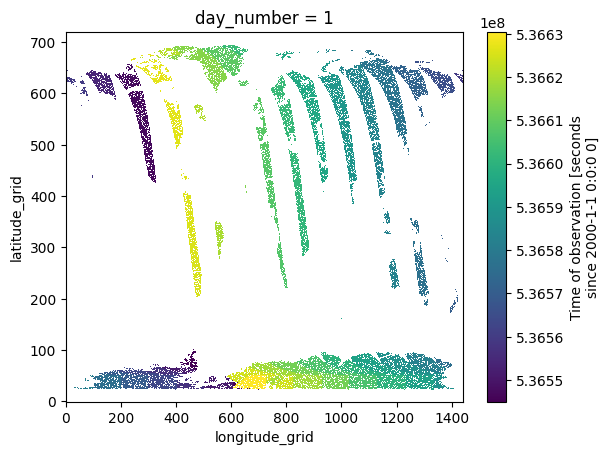

In [5]:
trainds.time.sel(day_number = 1, frequency_band= 1, swath_sector= 0).plot()

# TIME
It would be nice to add the time as a varialbe to predict. According to remss.com, all dates and times are Coordinates Universal Time (UTC). We should compute the local time for every pixel instead. Althoug it might not be necessary, since the network will also get latitude and longitude as inputs, so it might be able learn how to mix the three variables.

QUOTE. [https://www.remss.com/missions/windsat/](https://www.remss.com/missions/windsat/)

    ´We produce WindSat Daily and Time-Averaged (3-day, weekly and monthly) binary data files.  The files contain no headers or metadata and are a simple set of single-byte arrays as described below.  Since the data are stored as single bytes, no byte-swapping when transfering between machines is necessary.

    Gridded data files are organized according to observation date. All dates and times are Coordinated Universal Time (UTC), also known as Greenwich Mean Time (GMT), Zulu Time (Z), Universal Time (UT), and World Time.  Data products include daily and time averaged measurements as follows:

    Daily  	orbital data mapped to 0.25 degree grid 
    divided into 2 sets of maps based on ascending and descending passes 
    when adjacent passes overlap at high latitudes and daily "seam", earlier data is chosen. (See note below)
    3-Day  	average of 3 days ending on and including file date
    Weekly  	average of 7 days ending on and including the Saturday file date
    Monthly  	average of all data within the calendar month´

In any case, turning the values to seconds since the start of the day should reduce the order of magnitude, which could improve training.

## Notes:

We have a size 4 array as time for a single pixel, 2frequency_bands x 2swawths  (For some reason diferent frequencies also have diferent times ?? )

In [6]:
# given a point in the training data, extract the characteristics vector

xv = trainds.isel(
    {
        "latitude_grid": 300,
        "longitude_grid": 800
    }
)
variables = [
    "longitude",
    "latitude",
    "time",
    "quality_flag",
    "tbtoa",
    "surtep_ERA5",
    "airtep_ERA5",
]
xv = xv[variables]
xv

<xarray.Dataset> Size: 2kB
Dimensions:       (day_number: 21, frequency_band: 2, swath_sector: 2,
                   polarization: 2)
Coordinates:
    lat           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lon           float32 4B dask.array<chunksize=(), meta=np.ndarray>
  * day_number    (day_number) int32 84B 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 21
Dimensions without coordinates: frequency_band, swath_sector, polarization
Data variables:
    longitude     (day_number) float32 84B dask.array<chunksize=(1,), meta=np.ndarray>
    latitude      (day_number) float32 84B dask.array<chunksize=(1,), meta=np.ndarray>
    time          (day_number, frequency_band, swath_sector) float64 672B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    quality_flag  (day_number, swath_sector) float64 336B dask.array<chunksize=(1, 1), meta=np.ndarray>
    tbtoa         (day_number, polarization, frequency_band, swath_sector) float32 672B dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    surtep_ERA5   (day_number, swath_sector) float32 168B dask.array<chunksize=(1, 1), meta=np.ndarray>
    airtep_ERA5   (day_number, swath_sector) float32 168B dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

For every slice we have day_number(total) saples



In [124]:
# # Separate every dimention into it own numeric value

# for day in xv.day_number.values:

#     # time of observation, seconds since 2000-01-01 UTC: 2 frequencies x 2 swaths
#     asc_18gz_time, asc_37gh_time, des_18gz_time, des_37gh_time = xv.sel(day_number = day).time.values.flatten()

#     # Quality flags: 2 swaths
#     asc_qf, des_qf = xv.sel(day_number = day).quality_flag.values.flatten()

#     #Tbtoa components: 2pol x 2freq x 2swaths (in order: tb_<swath><freq><pol>)
#     tb_000, tb_001, tb_010, tb_011, tb_100, tb_101, tb_110, tb_111 = xv.sel(day_number = day).tbtoa.values.flatten()
    
#     xvalues ={
#         "lat" : float(xv.lat.values),
#         "lon" : float(xv.lon.values),
#         "day_number" : day,

#         "asc_18gz_time": asc_18gz_time,
#         "asc_37ghz_time" : asc_37gh_time,
#         "des_18gz_time" : des_18gz_time,
#         "des_37gh_time" : des_37gh_time ,
        
#         "asc_qf" : asc_qf,
#         "des_qf" : des_qf,

#         "tb_000" : tb_000,
#         "tb_001" : tb_001,
#         "tb_010" : tb_010,
#         "tb_010" : tb_010,
#         "tb_100" : tb_100,
#         "tb_101" : tb_101,
#         "tb_110" : tb_110,
#         "tb_011" : tb_011,
#     }
#     asc_surtep_ERA5, des_surtep_ERA5 = xv.sel(day_number = day).surtep_ERA5.values
#     asc_airtep_ERA5, des_airtep_ERA5 = xv.sel(day_number = day).airtep_ERA5.values

#     yvalues = {
#         "asc_surtep_ERA5": asc_surtep_ERA5,
#         "des_surtep_ERA5" : des_surtep_ERA5,
#         "asc_airtep_ERA5": asc_airtep_ERA5,
#         "des_airtep_ERA5" : des_airtep_ERA5
#     }

#     print(xvalues, yvalues)

# TODO

Too many missing values, the data collection alone will take 3s x 342944 = 12 days

NEXT STEP:

Create a train_test_mask for every day (day_number, lat, lon) such that is nan for not values (missing or ocean), 0 for test and 1 for training.

Index the data such that only lat,lon,day triplets with data are retrieved.



In [4]:
# New indexing method: (lon, lat, day) that have Tbtoa measurements

has_data_index = np.argwhere(~np.isnan(ds.tbtoa.sel(polarization = 0, frequency_band = 0).values))
has_data_index

# TODO: day_number starts at 1 in the original dataset, The index starts at 0!!!

array([[  0,  23,  92,   0],
       [  0,  23,  94,   0],
       [  0,  23,  96,   0],
       ...,
       [ 20, 693, 612,   1],
       [ 20, 694, 589,   0],
       [ 20, 694, 589,   1]], dtype=int64)

In [5]:
train_indeces , test_indeces = train_test_split(has_data_index, test_size=0.2, random_state=13)
train_test_mask = np.empty(shape=(21, 720, 1440, 2))
train_test_mask[:] = np.nan

train_test_mask[train_indeces[:,0], train_indeces[:,1], train_indeces[:,2],train_indeces[:,3]] = 1
train_test_mask[test_indeces[:,0], test_indeces[:,1], test_indeces[:,2],test_indeces[:,3]] = 0

In [6]:
ds["train_test_mask"] = (("day_number","latitude_grid","longitude_grid","swath_sector"),train_test_mask)

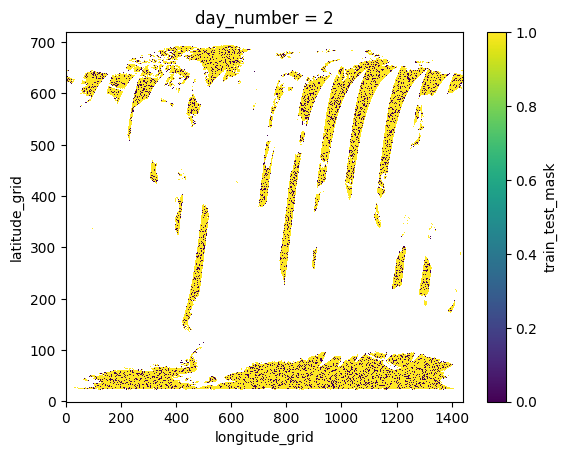

In [7]:
ds.train_test_mask.sel(day_number = 2, swath_sector=1).plot()

In [8]:
# With this mask, we can retrieve only the (lat, lon, day) triplets that have data in them. 
(np.isnan(train_test_mask)).sum() , (train_test_mask == 1).sum(), (train_test_mask == 0).sum()

(37868762, 4541470, 1135368)

In [89]:
# 4.5M datapoints, with 2pol x 2freq x 1tbtoa x1lat, x1lon, x1 quality_flag x4time variables.
# I need to keep track of the swath in every datapoint and also the day_number

In [91]:
# day, latg, long ,swath = has_data_index[2345]
# subset = ds.sel(day_number = day +1, latitude_grid = latg, longitude_grid=long, swath_sector = swath)
# subset.quality_flag

In [9]:
# For every index row, retrieve a training vector from the dataset
import pandas as pd
from datetime import datetime, timedelta

# Substract the number of seconds between the start of the year and the time origin
global_bias = (datetime(2017,1,1,0,0,0) - datetime(2000,1,1,0,0)).total_seconds()

batch_list = []
for day, latg, long ,swath in has_data_index[:64]:
    subset = ds.sel(day_number = day +1, latitude_grid = latg, longitude_grid=long, swath_sector = swath)

    time_18ghz, time_37ghz = subset.time.values.flatten()

    tbtoa_18ghz_V , tbtoa_37ghz_V, tbtoa_18ghz_H, tbtoa_37ghz_H = subset.tbtoa.values.flatten()

    # Also, this will be parallelized 

    xv ={
        "swath": swath,
        "day_number" : day + 1,
        "lat" : float(subset.lat.values),
        "lon" : float(subset.lon.values),

        "time_18ghz" : time_18ghz,
        "time_37ghz" : time_37ghz,

        "tbtoa_18ghz_V" : tbtoa_18ghz_V,
        "tbtoa_37ghz_V" : tbtoa_37ghz_V,
        "tbtoa_18ghz_H" : tbtoa_18ghz_H,
        "tbtoa_37ghz_H" : tbtoa_37ghz_H,

        "quality_flag" : float(subset.quality_flag.values),

        # Prediction data
        "surtep_ERA5" : float(subset.surtep_ERA5.values),
        "airtep_ERA5" : float(subset.airtep_ERA5.values),
    }   

    batch_list.append(xv)

batch_df = pd.DataFrame(batch_list)
#NOTE Error by 1, we need to substract 1 day, since the origin is 2017-01-01. not 2017-0-0.
batch_df["time_18ghz"] += - global_bias - (batch_df["day_number"] - 1)* 24 * 60 * 60
batch_df["time_37ghz"] += - global_bias - (batch_df["day_number"] - 1)* 24 * 60 * 60

batch_df

,swath,day_number,lat,lon,time_18ghz,time_37ghz,tbtoa_18ghz_V,tbtoa_37ghz_V,tbtoa_18ghz_H,tbtoa_37ghz_H,quality_flag,surtep_ERA5,airtep_ERA5
0,0,1,-84.125,203.125,37578.829244,37590.479244,201.902496,210.732498,157.117493,178.787491,320.0,264.928955,266.347595
1,0,1,-84.125,203.625,37578.029244,37589.529244,201.209991,210.157501,156.570007,178.097504,320.0,264.952728,266.327545
2,0,1,-84.125,204.125,37577.179244,37588.679244,200.364990,209.514999,155.922501,177.427490,320.0,264.968567,266.302887
3,0,1,-84.125,204.375,37576.629244,37588.179244,199.972504,209.159988,155.627502,177.147491,320.0,264.977997,266.294006
4,1,1,-84.125,204.875,37575.763306,37587.413306,199.082489,208.492493,154.992493,176.622498,320.0,265.008240,266.291718
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1,1,-84.125,306.375,13205.892640,13217.492640,211.149994,210.772491,165.319992,181.662491,64.0,253.763321,256.558502
60,1,1,-84.125,306.875,13205.042640,13216.592640,213.152496,212.104996,167.479996,183.022491,64.0,253.606277,256.529999
61,1,1,-84.125,307.125,13204.592640,13216.142640,214.119995,212.972504,168.292496,184.047501,64.0,253.524536,256.455597
62,1,1,-84.125,307.625,13203.692640,13215.342640,216.300003,214.474991,170.809998,185.375000,64.0,253.376892,256.195068


### Datavar inprovements_

Ranges are very different: 

    Normalization of some of the variables 
    Substract the number of seconds in the UTC day to the time variables
    and/or combine day_number and time

    quality flags are 8 bit codes (0,1,2,4,8,16,32,64) -> qualitative in some way? (split the dataset, normalise 0-1)

Sklearn category encoder 
[https://contrib.scikit-learn.org/category_encoders/](https://contrib.scikit-learn.org/category_encoders/)  

Since we have tons of data, we can also split the dataset again and train a model for each category


--- 

NOTE: I can not create a new dvar like this, it will take my computer all its RAM. Instead, add this time adjustment as a processing step in the training looop? or in the open_mfdataset function.

NEW IDEA:

When doing the batches, create a dataframe with the batch data, then simply compute:  

time = time - day_number*24*60*60 - year_origin (from 2000 to 2017 in secods)

DONE: 

The range is now as it should (0 to 86400) but it might be too many orders of manginute for a network to handle_
Maybe compute the corrected_time /100 and store as a float ? (or simply corrected_time//100 as int)

--- 

According to Maria, the passing time should be the same for every pixel (with the same frequency and swath)



In [138]:
day, latg, long, swath = has_data_index[12]
subset = ds.sel(swath_sector=swath, latitude_grid = latg, longitude_grid= long)

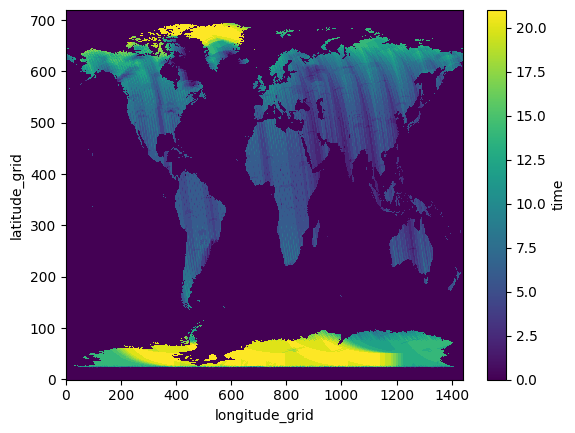

In [157]:
ds.time.sel(frequency_band=1, swath_sector=0).count(dim="day_number").plot()

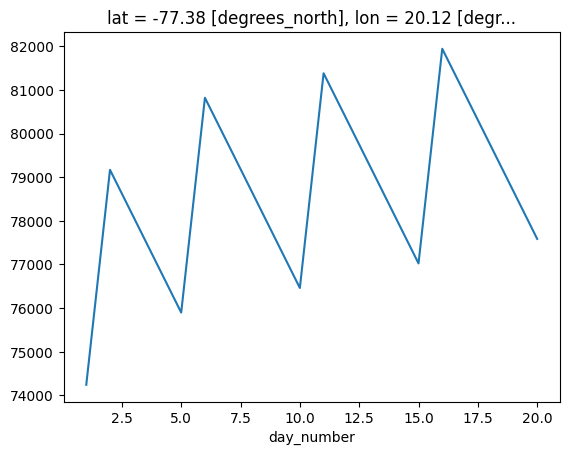

In [165]:
latg = 50
long = 800
swath = 0
subset = ds.sel(swath_sector=swath, latitude_grid = latg, longitude_grid= long, frequency_band=0)

(subset.time - (subset.day_number -1)* 24*60*60 - global_bias).plot()

--- 

Al least for this particular pixel, the passing time does change up to 8000s (2.2h) or close to the orbital period ... 

for the moment we keep the time as a separated varible

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential([
    Input((len(batch_df.columns)-2,)),
    Dense(10,activation="relu", name = "hiddenLayer"),
    Dense(1,activation="relu", name = "outputLayer")

])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hiddenLayer (Dense)             │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer = "adam",
    loss ="mse",
    metrics = ["mse"]
)

In [12]:
# Lets try to train it with a single batch

x_train,__, y_train, __= train_test_split(
    batch_df[[col for col in batch_df.columns if col not in ["surtep_ERA5","airtep_ERA5"]]],
    batch_df[["surtep_ERA5","airtep_ERA5"]]
    )

In [24]:
history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 66747.6172 - mse: 66747.6172  
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 66938.2344 - mse: 66938.2344
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 66937.2109 - mse: 66937.2109 
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67061.2422 - mse: 67061.2422 
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 66822.3750 - mse: 66822.3750 
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 66897.9766 - mse: 66897.9766  
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66678.1953 - mse: 66678.1953 
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 66863.6641 - mse: 66863.6641 
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 66968.9375 - mse: 66968.9375  
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 66831.6641 - mse: 66831.6641  


--- 

Batch training



In [ ]:
def get_training_batch(index_list: list, ds: xr.Dataset) -> tuple[pd.DataFrame, pd.DataFrame]:
    """ 
    Get a pair of X and y data to train, given a list of indeces.
    ds: open windsat xarray dataset
    """
    # TODO: async version, geting the data batches and training the model should not be done in series.

    # Substract the number of seconds between the start of the year and the time origin
    global_bias = (datetime(2017,1,1,0,0,0) - datetime(2000,1,1,0,0)).total_seconds()

    batch_list = []
    for day, latg, long ,swath in index_list:
        subset = ds.sel(day_number = day +1, latitude_grid = latg, longitude_grid=long, swath_sector = swath)

        time_18ghz, time_37ghz = subset.time.values.flatten()

        tbtoa_18ghz_V , tbtoa_37ghz_V, tbtoa_18ghz_H, tbtoa_37ghz_H = subset.tbtoa.values.flatten()

        # Also, this will be parallelized 

        xv ={
            "swath": swath,
            "day_number" : day + 1,
            "lat" : float(subset.lat.values),
            "lon" : float(subset.lon.values),

            "time_18ghz" : time_18ghz,
            "time_37ghz" : time_37ghz,

            "tbtoa_18ghz_V" : tbtoa_18ghz_V,
            "tbtoa_37ghz_V" : tbtoa_37ghz_V,
            "tbtoa_18ghz_H" : tbtoa_18ghz_H,
            "tbtoa_37ghz_H" : tbtoa_37ghz_H,

            "quality_flag" : float(subset.quality_flag.values),

            # Prediction data
            "surtep_ERA5" : float(subset.surtep_ERA5.values),
            "airtep_ERA5" : float(subset.airtep_ERA5.values),
        }   

        batch_list.append(xv)

    batch_df = pd.DataFrame(batch_list)
    #NOTE Error by 1, we need to substract 1 day, since the origin is 2017-01-01. not 2017-0-0.
    batch_df["time_18ghz"] += - global_bias - (batch_df["day_number"] - 1)* 24 * 60 * 60
    batch_df["time_37ghz"] += - global_bias - (batch_df["day_number"] - 1)* 24 * 60 * 60

    y_vars = ["surtep_ERA5","airtep_ERA5"]

    x_train = batch_df[[col for col in batch_df.cols if col not in y_vars]]
    y_train = batch_df[y_vars]
    return x_train, y_train




In [18]:
tranin_indeces, test_indeces = train_test_split(has_data_index, test_size= 0.3, random_state=13)

In [26]:
# TODO: create a common history fot all training loops and append the losses and epochs into a list.



{'loss': [66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625],
 'mse': [66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625,
  66909.8515625]}